# ARGO DOXY profile adjustment check

This script will read in the synthetic profile

1) Read the calibration comments: 
  
2) Classify the calibration method into 4 groups
- Type 1: Gain correction using surface climatological saturation (Takeshita et al, 2013)
- Type 2: Gain correction using surface in-air measurement at the surface (Johnson et al., 2015)
- Type 3: Other calibration methods
- Type 4: No calibratin data available

3) Graph the relative proportion of DOXY float profiles

4) Record the classification table

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate as itp
from scipy import stats as stats
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

In [2]:
# generate index for downloaded synthetic profiles
os.system('ls data/*.nc > available_floats.txt')
fn=pd.read_csv('available_floats.txt',header=None,names=['file'])

In [3]:
# open the profile data file, count the number of profiles and depth levels
N=np.size(fn)
Nprf=np.empty((N,))
Nprf_good=np.empty((N,))
Nlev=np.empty((N,))
N_calib_comm=np.empty((N,))
calib_comm=np.empty((N),dtype='U256')
QCflag=np.empty((N),dtype='U16')
WMOID=np.empty((N,),dtype=int)
#
! mkdir -p temporary_files
#
# loop over all floats
for n in range(0,N):
    WMOID[n]=int(fn['file'][n].replace('/','_').split('_')[1])
    if (np.remainder(n,50)==0):
        print('completed '+str(n)+' floats')
    ds=xr.open_dataset(fn['file'][n])
    Ntmp=np.shape(ds['PRES']) # get pressure data
    Nprf[n]=Ntmp[0]           # count the number of profiles
    Nlev[n]=Ntmp[1]           # count the number of pressure measurements
    # get QC flags
    date_qc=ds['JULD_QC'].astype(int)
    pos_qc=ds['POSITION_QC'].astype(int)
    o2_qc=ds['PROFILE_DOXY_QC'].astype(str)
    o2qcflg=ds['DOXY_QC'].astype(str)
    o2aqcflg=ds['DOXY_ADJUSTED_QC'].astype(str)
    # read in calibration comments for all profiles
    doxy_calib_comm=ds['SCIENTIFIC_CALIB_COMMENT'][:,0,3]
    # count the number of DOXY profiles
    Nprf_good[n]=np.size(doxy_calib_comm)
    # Determine unique O2 calibration methods
    com256=doxy_calib_comm.to_numpy().astype('U256')
    com10=com256.astype('U10')
    # replace empty comments with 'unknown'
    com2560=np.where((com10!='          '),com256,'unknown')
    tmp,count=np.unique(com2560,return_counts=True)    
    N_calib_comm[n]=np.size(tmp)
    tmp0=tmp[np.argmax(count)]
    calib_comm[n]=tmp0
    #
print('done!')

completed 0 floats
completed 50 floats
completed 100 floats
completed 150 floats
completed 200 floats
completed 250 floats
completed 300 floats
completed 350 floats
completed 400 floats
completed 450 floats
completed 500 floats
completed 550 floats
completed 600 floats
completed 650 floats
completed 700 floats
completed 750 floats
completed 800 floats
completed 850 floats
completed 900 floats
completed 950 floats
completed 1000 floats
completed 1050 floats
completed 1100 floats
completed 1150 floats
completed 1200 floats
completed 1250 floats
completed 1300 floats
completed 1350 floats
completed 1400 floats
completed 1450 floats
completed 1500 floats
done!


In [4]:
calib_types, calib_count = np.unique(calib_comm, return_counts=True)
print('There are '+str(np.size(calib_types))+' independent calibration method comments. ')
# calibration statistics
a=np.array([calib_count, calib_types])
calib_stats=pd.DataFrame(data=a.T,
                        columns=['Number of floats','Calibration Type'])
calib_stats.to_csv('float_calibration_table.csv')
# calibration by floats
a=np.array([WMOID, calib_comm])
calib_by_wmoid=pd.DataFrame(data=a.T,
                        columns=['WMOID','Calibration Type'])
calib_by_wmoid.to_csv('calibration_by_WMOID.csv')
#np.save('calib_comm_v2.npy',calib_comm)
#np.savez('calib_comm_v3.npz',calib_comm=calib_comm,WMOID=WMOID)

There are 103 independent calibration method comments. 


In [9]:
Nc=[]
# type 1: Gain correction using surface climatological saturation (WOA). Takeshita et al (2013)
index1=[10,11,13,14,15,16,19,20,22,23,26,28,29,30,31,37,39,40,41,42,46,49,
        50,54,63,68,69,70,71,72,73,78,79,80,86,87,89,90,97,98,99,100]
Nc.append(np.sum(calib_count[index1]))
# type 2: Gain correction using surface in-air measurement at the surface (Bittig and Kortzinger 2015; Johnson et al 2015)
index2=[17,18,21,24,25,27,35,38,43,44,45,51,64,66,67,74,81,91,92]
Nc.append(np.sum(calib_count[index2]))
# type 3: Other calibration methods
index3=[0,1,2,3,4,5,6,7,8,9,12,34,36,47,52,53,56,58,75,76,77,88,101]
Nc.append(np.sum(calib_count[index3]))
# type 4: No calibration data available / bad data
index4=[32,33,48,55,57,59,60,61,62,65,82,83,84,85,93,94,95,96,102]
Nc.append(np.sum(calib_count[index4]))
print(Nc)
print(np.sum(Nc))
print(np.size(index1)+np.size(index2)+np.size(index3)+np.size(index4))

[562, 359, 172, 435]
1528
103


<Figure size 504x288 with 0 Axes>

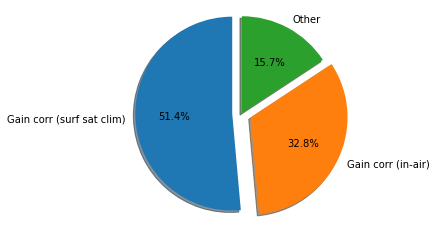

In [11]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,4))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Gain corr (surf sat clim)', 'Gain corr (in-air)', 'Other'
sizes = Nc[:3]
explode = (0.1, 0.1, 0)  # only "explode" the 1st and 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('pie_correction_type_v3.pdf')
plt.show()

In [12]:
# catogorize calibration type
calib_group=np.zeros(np.size(calib_comm),dtype=int)
calib_groupname=np.zeros(np.size(calib_comm),dtype='U64')
for n in range(np.size(index1)):
    ind=(calib_comm==calib_types[index1[n]])
    calib_group[ind]=1
    calib_groupname[ind]='Type 1: Gain Corr, surf sat clim'
for n in range(np.size(index2)):
    ind=(calib_comm==calib_types[index2[n]])
    calib_group[ind]=2
    calib_groupname[ind]='Type 2: Gain Corr, in-air'
for n in range(np.size(index3)):
    ind=(calib_comm==calib_types[index3[n]])
    calib_group[ind]=3
    calib_groupname[ind]='Type 3: Other'
for n in range(np.size(index4)):
    ind=(calib_comm==calib_types[index4[n]])
    calib_group[ind]=4
    calib_groupname[ind]='Type 4: Unknown/bad data'

In [13]:
a=np.array([WMOID, calib_group, calib_groupname, calib_comm, QCflag])
float_stats=pd.DataFrame(data=a.T,
    columns=['WMO ID','Calib indicator','Calib group type','Calibration comment','QC flag'])
float_stats.to_csv('float_calibration_statistics_ver.Feb1.csv')
float_stats

,WMO ID,Calib indicator,Calib group type,Calibration comment,QC flag
0,1900650,3,Type 3: Other,No significant oxygen drift detected - Calibra...,
1,1900651,3,Type 3: Other,No significant oxygen drift detected - Calibra...,
2,1900652,3,Type 3: Other,No significant oxygen drift detected - Calibra...,
3,1900722,3,Type 3: Other,DOXY_ADJUSTED computed using Stern-Volmer equa...,
4,1900943,1,"Type 1: Gain Corr, surf sat clim","Adjusted with WOA climatology, optode simple c...",
...,...,...,...,...,...
1523,7900863,4,Type 4: Unknown/bad data,unknown,
1524,7900881,4,Type 4: Unknown/bad data,unknown,
1525,7900907,4,Type 4: Unknown/bad data,unknown,
1526,7900915,4,Type 4: Unknown/bad data,unknown,
